# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

**Данные о клиентах банка:**

  * age (возраст);
  * job (сфера занятости);
  * marital (семейное положение);
  * education (уровень образования);
  * default (имеется ли просроченный кредит);
  * housing (имеется ли кредит на жильё);
  * loan (имеется ли кредит на личные нужды);
  * balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

  * contact (тип контакта с клиентом);
  * month (месяц, в котором был последний контакт);
  * day (день, в который был последний контакт);
  * duration (продолжительность контакта в секундах).

**Прочие признаки:**

  * campaign (количество контактов с этим клиентом в течение текущей кампании);
  * pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
  * previous (количество контактов до текущей кампании)
  * poutcome (результат прошлой маркетинговой кампании).

Целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её необходимо предсказать.

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
print(df.info())
print('__________________________________________________________________________________________')
print(f"В признаке balance пропущено - {df[(df['balance'].isnull())].shape[0]} значений")
# df[(df['balance'].isnull())]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
None
__________________________________________________________________________________________
В п

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
print(df['job'].nunique())
print(df['job'].unique())
# "администратор", "техник", "услуги", "менеджмент", "пенсионер", "рабочий", "безработный", 
# "предприниматель", "горничная", "неизвестный", "самозанятый", "студент"
# 'unknown' - можно считать пропуском, так как значение не соотвествует признаку
df['job'].value_counts()

12
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']


management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
temp_str = "33333333333333,33"   # временно заменим NAN
df['balance'].fillna(temp_str , inplace=True)

data_balance = df['balance']

lam_bal = lambda x: float(x.replace(" ", "").replace("$", "").replace(",", "."))
df['balance'] = data_balance.apply(lam_bal)

df['balance']


0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

df.loc[(df.balance == float(temp_str.replace(",", "." ))), ('balance')] = np.NAN  # возвращаем NAN, для расчёта среднего не искажённого выедённым значением
mean_balance = round(df['balance'].mean(), 3)

mean_balance

1529.129

### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
educ_mode = df['education'].mode()[0]
job_mode = df['job'].mode()[0]
# print(educ_mode)
# print(job_mode)
df['education'].value_counts() #  unknown - также является пропуском

# job и education, меням на модальные значения
df.loc[(df.education == 'unknown'), ('education')] = educ_mode
df.loc[(df.job == 'unknown'), ('job')] = job_mode 

### Задание 6

In [9]:
# удалите все выбросы для признака balance
median_balance = df['balance'].median()

df['balance'].fillna(median_balance , inplace=True)

mask_educ = df['education'] == educ_mode
mask_job = df['job'] == job_mode

mean_bal_mode_2 = df[(mask_educ) & (mask_job)]['balance'].mean()

print(f"Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: {round(mean_bal_mode_2, 3)}")

df_copy = df.copy

# Поиск выбросов по методу Тьюки
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    """    
    Добавьте в нее параметры left и right, которые задают число IQR влево и вправо от границ ящика (пусть по умолчанию они равны 1.5).
    Функция, как и раньше должна возвращать потенциальные выбросы и очищенный DataFrame.
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    print(f'Нижняя граница по методу Тьюки: {lower_bound}')
    print(f'Верхняя граница по методу Тьюки: {upper_bound}')
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(df, 'balance', left=1.5, right=1.5)

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

outlers = df[(df['balance']>= -2241.0) | (df['balance']<= 4063.0)]
df = df.drop(outliers.index)



Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: 1598.883
Нижняя граница по методу Тьюки: -2241.0
Верхняя граница по методу Тьюки: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

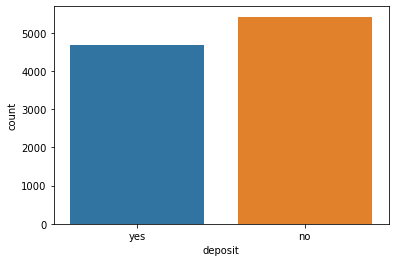

In [10]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=df, x='deposit')
df['deposit'].value_counts()
# Классы можно принять сбалансированными

### Задания 2 и 3

In [11]:
# Рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

# Каков максимальный возраст клиента банка?
print(f"Максимальный возраст клиента банка: {df['age'].max()} лет.")

# Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.
print(f"Минимальная продолжительность разговора с клиентом банка: {df['duration'].min()} с.")


Максимальный возраст клиента банка: 95 лет.
Минимальная продолжительность разговора с клиентом банка: 2 с.


### Задания 4 и 5

Text(0, 0.5, 'Количество контактов в месяц')

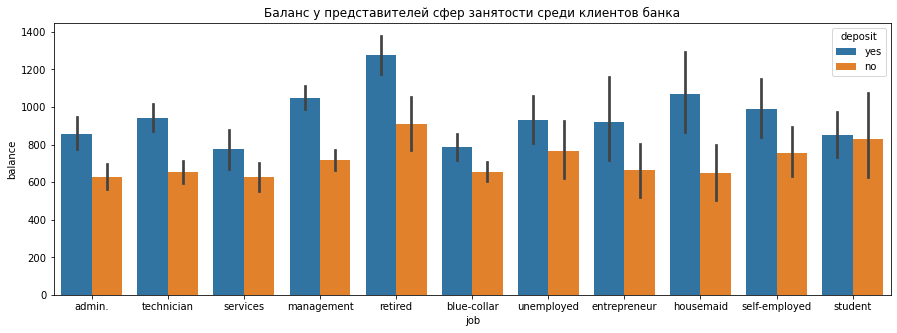

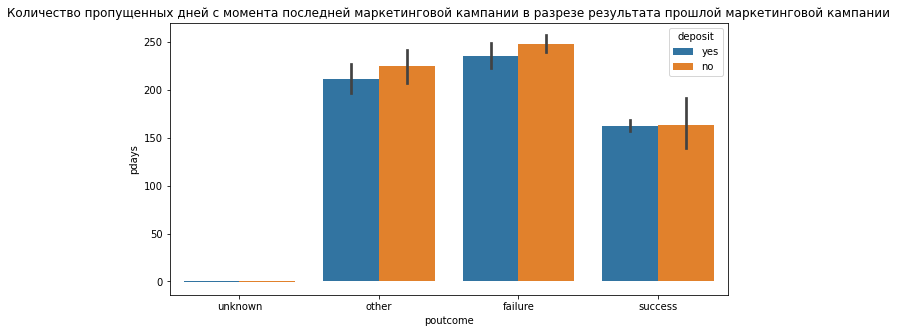

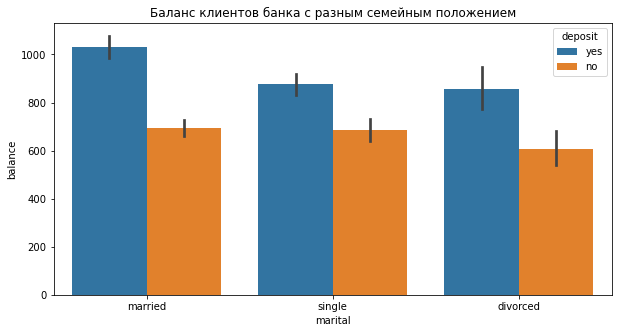

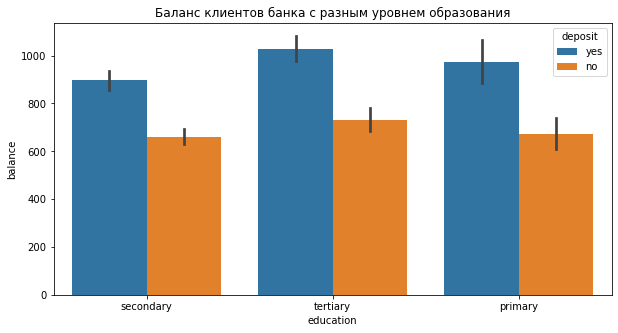

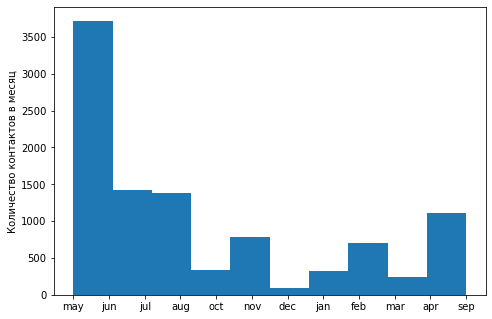

In [12]:
# df.info()
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include = 'object')
#постройте визуализации, иллюстрирующие результаты


# Сколько всего сфер занятости представлено среди клиентов банка? 
fig_1 = plt.figure(figsize=(15, 5))
barplot = sns.barplot(
    data=df,
    x='job',
    y='balance',
    hue='deposit'
)
barplot.set_title('Баланс у представителей сфер занятости среди клиентов банка') 

# В каждый ли месяц проходила маркетинговая кампания?
fig_2_1 = plt.figure(figsize=(10, 5))
barplot = sns.barplot(
    data=df,
    x='poutcome',
    y='pdays',
    hue='deposit'
)
barplot.set_title('Количество пропущенных дней с момента последней маркетинговой кампании в разрезе результата прошлой маркетинговой кампании')

# Какое семейное положение встречается чаще всего? 
fig_3 = plt.figure(figsize=(10, 5))
barplot = sns.barplot(
    data=df,
    x='marital',
    y='balance',
    hue='deposit'
)
barplot.set_title('Баланс клиентов банка с разным семейным положением')

# А образование? 
fig_4 = plt.figure(figsize=(10, 5))
barplot = sns.barplot(
    data=df,
    x='education',
    y='balance',
    hue='deposit'
)
barplot.set_title('Баланс клиентов банка с разным уровнем образования') 

fig = plt.figure() # facecolor='lightgreen'
axes = fig.add_axes([0, 0, 1, 1])
# axes.hist(df.groupby('month')['daily_vaccinations'].sum())
axes.hist(df['month'])
axes.set_ylabel('Количество контактов в месяц')


### Задание 6

no     5424
yes    4681
Name: deposit, dtype: int64

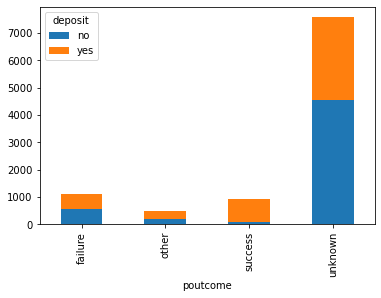

In [13]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

df['deposit'].value_counts()

### Задание 7

<AxesSubplot:xlabel='month'>

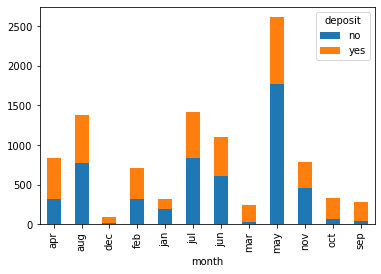

In [14]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
types = df.groupby("month")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 8

30-40    3961
40-50    2382
50-60    1654
<30      1455
60+       653
Name: age_group, dtype: int64

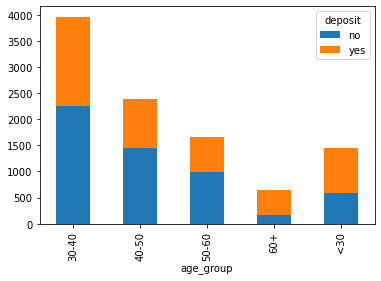

In [15]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(age):
    out = ''
    if age<30: out = '<30'
    if age>=30 and age<40: out = '30-40'
    if age>=40 and age<50: out = '40-50'
    if age>=50 and age<60: out = '50-60'
    if age>=60: out = '60+'
    return out
    
df['age_group'] = df['age'].apply(age_group) # создаётся новый признак по возрастным группам

types = df.groupby("age_group")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

df['age_group'].value_counts()


### Задания 9 и 10

<AxesSubplot:xlabel='marital'>

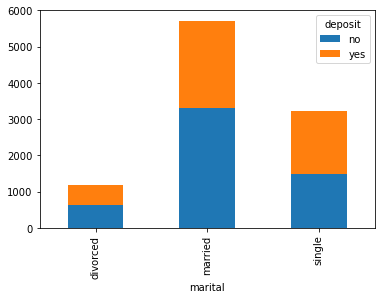

In [16]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
types = df.groupby("marital")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

<AxesSubplot:xlabel='education'>

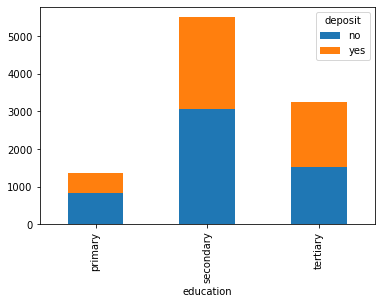

In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
types = df.groupby("education")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

<AxesSubplot:xlabel='job'>

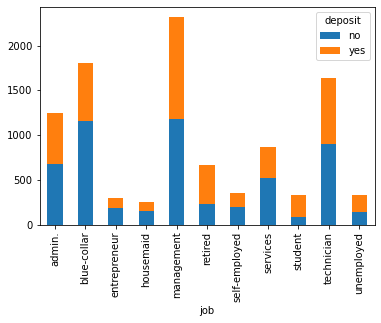

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
types = df.groupby("job")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 11

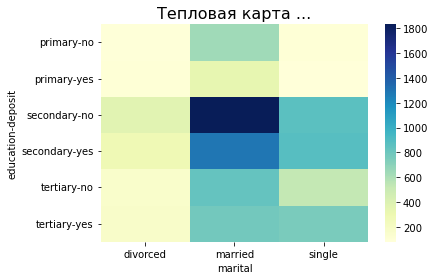

In [19]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)  
# types = pd.pivot_table(df, #[(df['deposit'] == 'yes')],
#                values='deposit', 
#                index=['education'],
#                columns=['marital'], 
#                 aggfunc='value_counts')
# 
# types.plot(kind='bar', stacked='True')

types_1 = pd.pivot_table(df, #[(df['deposit'] == 'yes')],
               values='deposit', 
               index=['education'],
               columns=['marital'], 
                aggfunc='value_counts')

heatmap = sns.heatmap(data=types_1, cmap='YlGnBu')
heatmap.set_title('Тепловая карта ...', fontsize=16);



## Часть 1. Знакомство с данными, обработка пропусков и выбросов

**Данные о клиентах банка:**

  * age (возраст);
  * job (сфера занятости);
  * marital (семейное положение);
  * education (уровень образования);
  * default (имеется ли просроченный кредит);
  * housing (имеется ли кредит на жильё);
  * loan (имеется ли кредит на личные нужды);
  * balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

  * contact (тип контакта с клиентом);
  * month (месяц, в котором был последний контакт);
  * day (день, в который был последний контакт);
  * duration (продолжительность контакта в секундах).

**Прочие признаки:**

  * campaign (количество контактов с этим клиентом в течение текущей кампании);
  * pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
  * previous (количество контактов до текущей кампании)
  * poutcome (результат прошлой маркетинговой кампании).

## Часть 3: преобразование данных

### Задание 1

In [20]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder# instantiate labelencoder object
le = preprocessing.LabelEncoder() # указываем столбец для кодирования

df['education'] = le.fit_transform(df['education'])
df['age'] = le.fit_transform(df['age'])
print('Сумма получившихся значений для признака education: ', df['education'].sum())

# from sklearn.preprocessing import LabelBinarizer
# encoder = LabelBinarizer()
# df['deposit'] = encoder.fit_transform(df['deposit'])
# 
# round(df['deposit'].std(), 3)


Сумма получившихся значений для признака education:  11995


### Задания 2 и 3

In [21]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

print (f"Стандартное отклонение deposit {round(st.stdev(df['deposit']),3)}")
print(f"Суммма средних default, housing, loan {round( st.mean(df['default'])+st.mean(df['housing'])+st.mean(df['loan']),3)}")

Стандартное отклонение deposit 0.499
Суммма средних default, housing, loan 0.635


### Задание 4

In [22]:
# создайте дамми-переменные
df_dummies =pd.get_dummies(df)
df_dummies.shape

(10105, 50)

### Задания 5 и 6

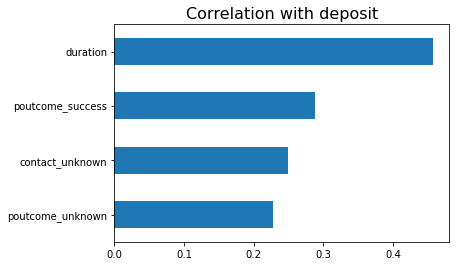

In [23]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = df_dummies.corr()
# fig, ax = plt.subplots(figsize=(25,30))
# sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

# Удалим самые сильно скоррелированные пары
# df_dummies = df_dummies.drop([], axis=1)

# Проверяем, что сильно скоррелированных признаков не осталось
# sns.heatmap(df_dummies.corr(), annot=True, linewidths=.5, ax=ax)

### Задания 7 и 8

In [24]:

X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (6770, 49) (6770,)
Test: (3335, 49) (3335,)


In [25]:
# рассчитайте необходимые показатели
print(f"Среднее значение целевыой переменной в тестовой выборке {round(st.mean(y_test),2)}")


Среднее значение целевыой переменной в тестовой выборке 0.46


### Задание 9

In [26]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# df.select_dtypes(include='number') # мы получим только те столбцы, которые являются числовыми.
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
columns = selector.get_feature_names_out()
 
print(columns)
X_train = X_train[columns]
X_test = X_test[columns]
# X_test


['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown' 'age_group_60+']


### Задание 10

In [27]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

print(X_test_scaled[:, 0].mean())  # для признака balance, обратите внимание именно на столбец

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [28]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))

Test accuracy: 0.804


### Задания 2,3,4

In [30]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    random_state=42,
    criterion = 'entropy'
    )

#Обучаем модель
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.73


### Задание 5

In [35]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    #'min_samples_split':  [2, 5, 7, 10],
    'max_depth':[3, 5, 6, 7, 8, 9, 10, 11, 12, 13]
}
            
grid_search_tree = GridSearchCV(
    estimator=dt, 
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  
           

%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))


CPU times: total: 188 ms
Wall time: 242 ms
f1_score на обучающем наборе: 0.84
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [36]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
%time rf.fit(X_train_scaled, y_train)

y_train_pred = rf.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(rf.score(X_test_scaled, y_test)))
y_test_pred = rf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('recall на тестовом наборе:: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))

CPU times: total: 500 ms
Wall time: 502 ms
f1_score на обучающем наборе: 0.84
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.816
recall на тестовом наборе:: 0.831


### Задания 2 и 3

In [37]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

%time gb.fit(X_train_scaled, y_train)

y_test_pred_gb = rf.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred_gb)))

CPU times: total: 3.33 s
Wall time: 3.33 s
f1_score на тестовом наборе: 0.816


### Задание 4

In [38]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

#Обучаем модель
%time stack.fit(X_train_scaled, y_train)

y_train_pred = stack.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(rf.score(X_test_scaled, y_test)))
y_test_pred = stack.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('recall на тестовом наборе:: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('precision на тестовом наборе:: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))

CPU times: total: 18.5 s
Wall time: 18.3 s
f1_score на обучающем наборе: 0.85
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.807
recall на тестовом наборе:: 0.804
precision на тестовом наборе:: 0.810


### Задание 5

In [51]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE

X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns) 
X_train_scaled

estimator = gb
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
columns_gb = selector.get_feature_names_out()
columns_gb

array(['balance', 'duration', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [39]:
%%time
import optuna
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf)
                                          #random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
y_test_pred = model.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2022-10-13 22:42:55,720] A new study created in memory with name: RandomForestClassifier
[I 2022-10-13 22:42:56,655] Trial 0 finished with value: 0.8425692695214105 and parameters: {'n_estimators': 167, 'max_depth': 21, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8425692695214105.
[I 2022-10-13 22:42:57,356] Trial 1 finished with value: 0.8444934614778635 and parameters: {'n_estimators': 125, 'max_depth': 28, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8444934614778635.
[I 2022-10-13 22:42:58,277] Trial 2 finished with value: 0.8411597856917743 and parameters: {'n_estimators': 169, 'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8444934614778635.
[I 2022-10-13 22:42:59,081] Trial 3 finished with value: 0.8455029771231589 and parameters: {'n_estimators': 147, 'max_depth': 22, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8455029771231589.
[I 2022-10-13 22:42:59,895] Trial 4 finished with value: 0.851968503937008 and parameters: {'n_e

Наилучшие значения гиперпараметров {'n_estimators': 146, 'max_depth': 23, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
accuracy на тестовом наборе: 0.82
CPU times: total: 28.9 s
Wall time: 28.9 s
